In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

In [2]:
data_dir = r"/kaggle/input/drugsvision/Data Combined"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
df

,filepaths,labels
0,/kaggle/input/drugsvision/Data Combined/DayZin...,DayZinc
1,/kaggle/input/drugsvision/Data Combined/DayZin...,DayZinc
2,/kaggle/input/drugsvision/Data Combined/DayZin...,DayZinc
3,/kaggle/input/drugsvision/Data Combined/DayZin...,DayZinc
4,/kaggle/input/drugsvision/Data Combined/DayZin...,DayZinc
...,...,...
9995,/kaggle/input/drugsvision/Data Combined/Bioflu...,Bioflu
9996,/kaggle/input/drugsvision/Data Combined/Bioflu...,Bioflu
9997,/kaggle/input/drugsvision/Data Combined/Bioflu...,Bioflu
9998,/kaggle/input/drugsvision/Data Combined/Bioflu...,Bioflu


In [4]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

In [5]:
batch_size = 64
img_size = (224, 224)  # Resize images
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [7]:
# Data augmentation for training
tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test data generator without augmentation
ts_gen = ImageDataGenerator()

# Create generators
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                        target_size=img_size, class_mode='categorical',
                                        batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                        target_size=img_size, class_mode='categorical',
                                        batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       batch_size=batch_size, shuffle=False)

Found 8000 validated image filenames belonging to 10 classes.
Found 1200 validated image filenames belonging to 10 classes.
Found 800 validated image filenames belonging to 10 classes.


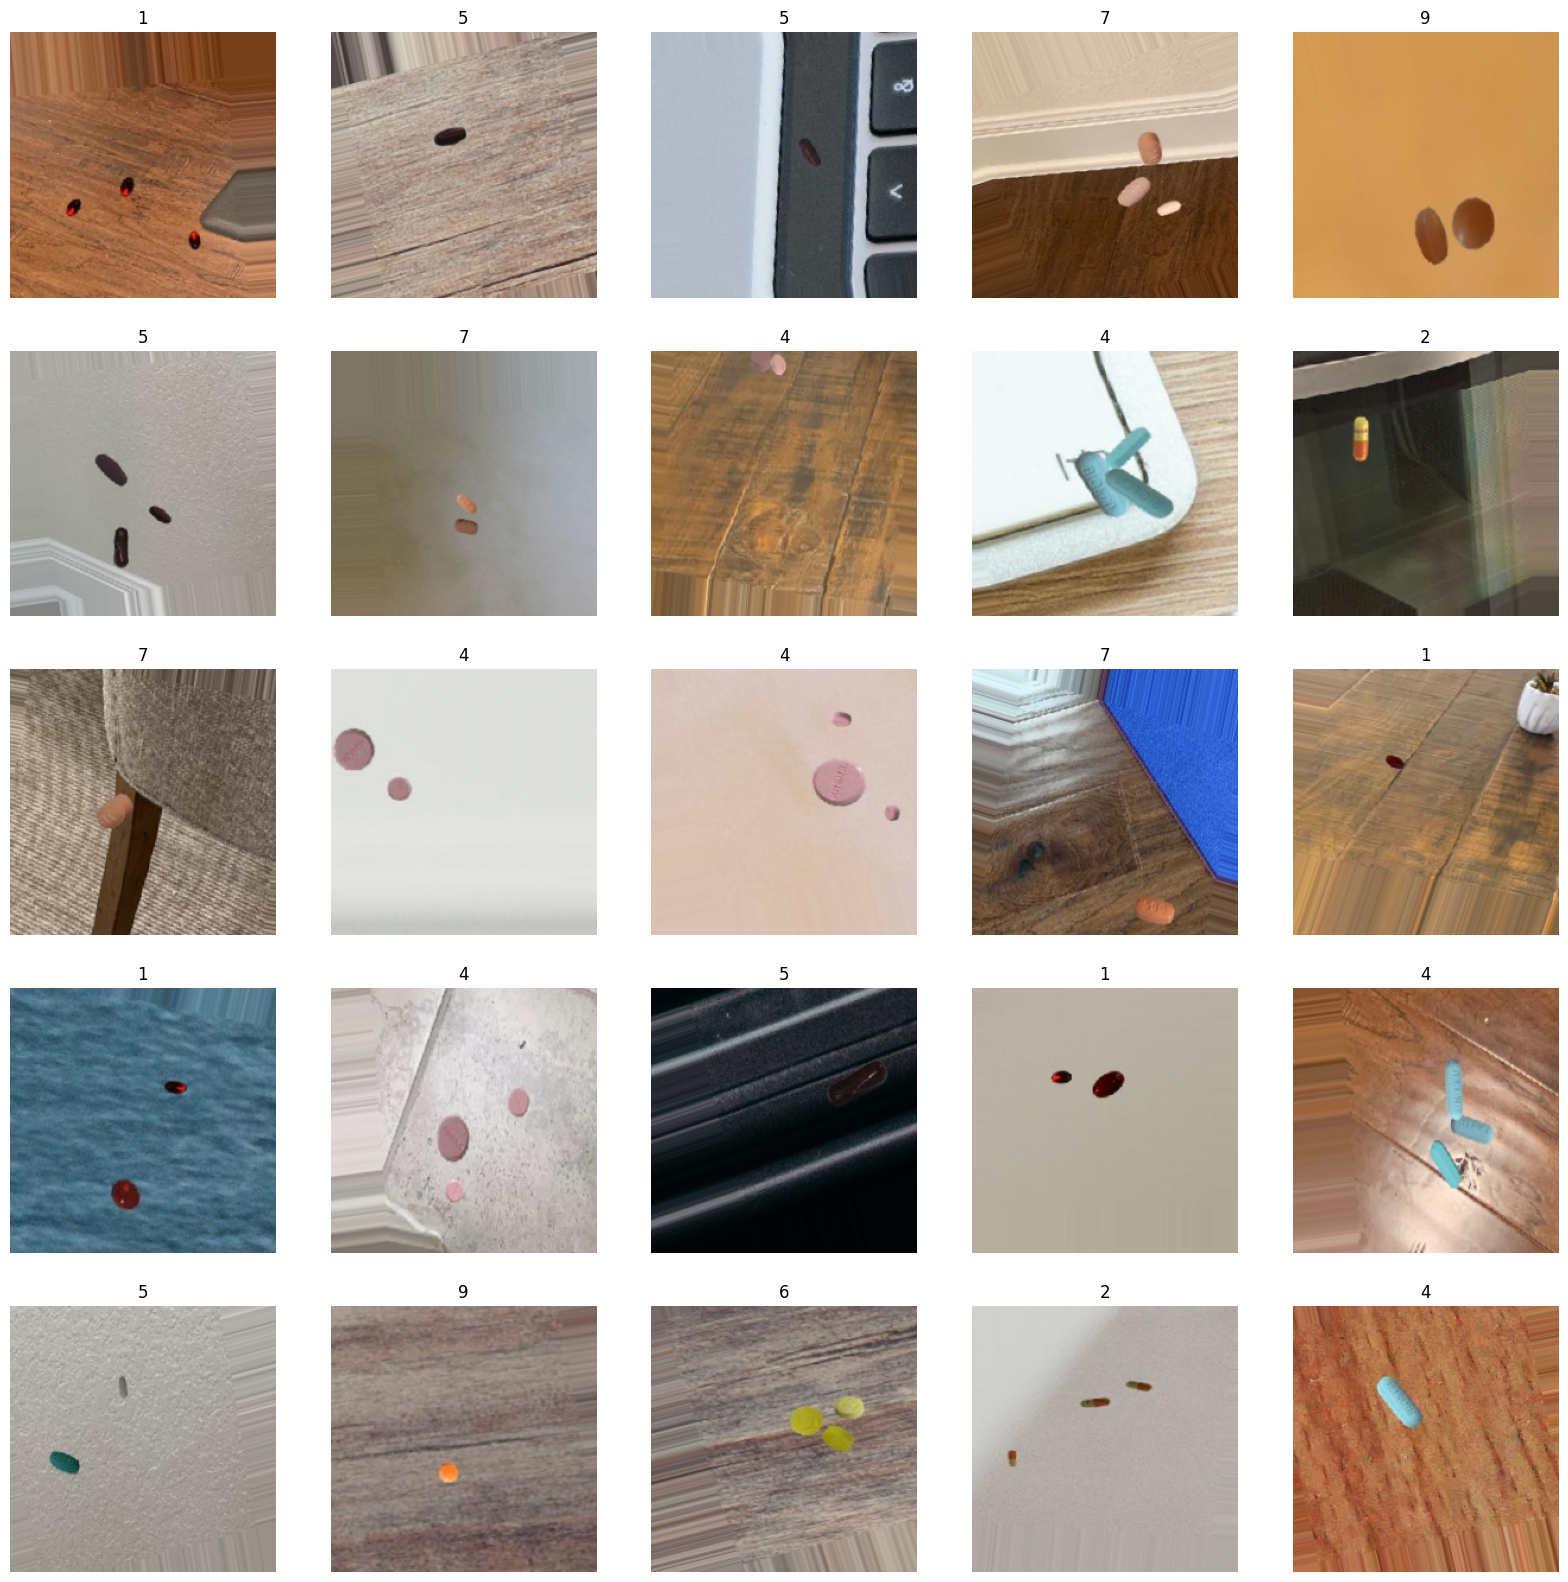

In [8]:
images, labels = next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255  # Scale to [0, 1]
    plt.imshow(image)
    plt.title(train_gen.classes[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

In [14]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer=regularizers.l2(0.03), activation='relu'),  # Increased regularization
    Dropout(rate=0.55),  # Increased dropout
    Dense(len(train_gen.class_indices), activation='softmax')  # Output layer
])

In [15]:
tr_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],  # Add brightness shift
    horizontal_flip=True,
    fill_mode='nearest'
)

# Compile model with a lower learning rate
model.compile(
    optimizer=Adamax(learning_rate=0.0001),  # Reduce learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Keep callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3,  # More aggressive factor
    patience=2,  # Reduce learning rate sooner
    min_lr=1e-7  # Reduce minimum learning rate
)

In [ ]:
epochs = 20

# Train the model
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 247s 861ms/step - accuracy: 0.1648 - loss: 16.0519 - val_accuracy: 0.6675 - val_loss: 13.5126 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 766ms/step - accuracy: 0.5456 - loss: 13.7034 - val_accuracy: 0.9017 - val_loss: 12.2086 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 758ms/step - accuracy: 0.7870 - loss: 12.3890 - val_accuracy: 0.9583 - val_loss: 11.4108 - learning_rate: 1.0000e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 758ms/step - accuracy: 0.8786 - loss: 11.4762 - val_accuracy: 0.9717 - val_loss: 10.6886 - learning_rate: 1.0000e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 753ms/step - accuracy: 0.9124 - loss: 10.6967 - val_accuracy: 0.9833 - val_loss: 9.9612 - learning_rate: 1.0000e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 769ms/step - accuracy: 0.9383 - loss: 9.9021 - val_accuracy: 0.9867 - val_loss: 9.2200 - learning_rate: 1.0000e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 726ms/step
              precision    recall  f1-score   support

      Alaxan       1.00      1.00      1.00        78
    Bactidol       1.00      1.00      1.00        83
      Bioflu       1.00      1.00      1.00        69
    Biogesic       1.00      1.00      1.00        77
     DayZinc       1.00      1.00      1.00        93
    Decolgen       1.00      1.00      1.00        90
    Fish Oil       1.00      1.00      1.00        75
    Kremil S       1.00      1.00      1.00        91
     Medicol       1.00      1.00      1.00        66
      Neozep       1.00      1.00      1.00        78

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



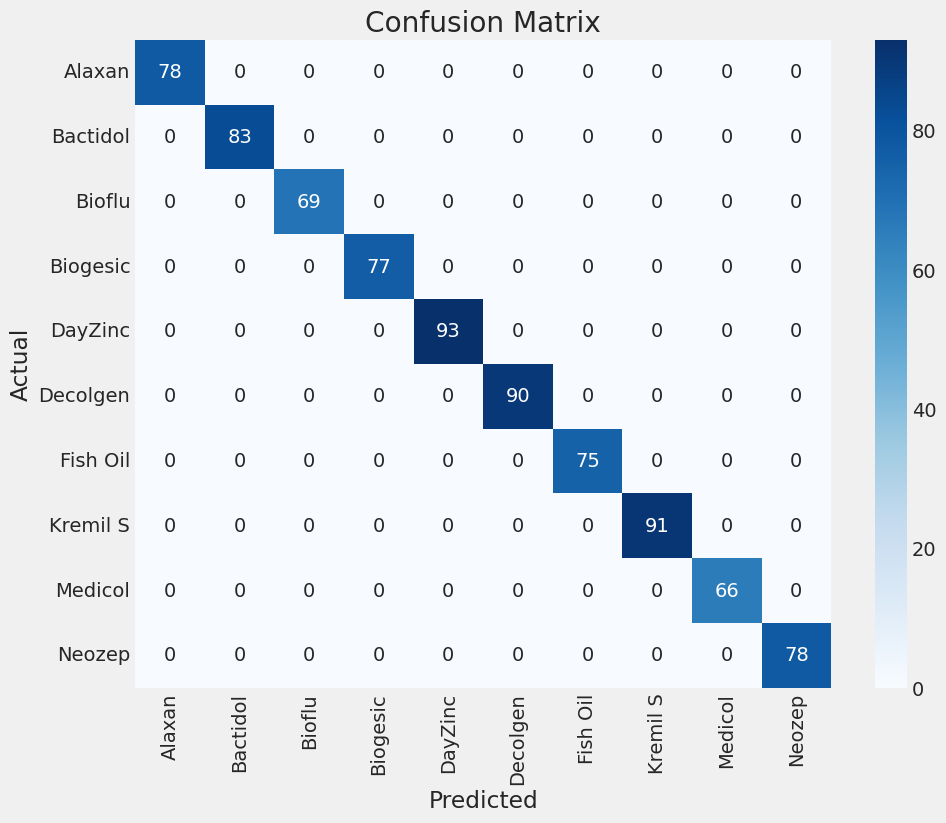

In [37]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=train_gen.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

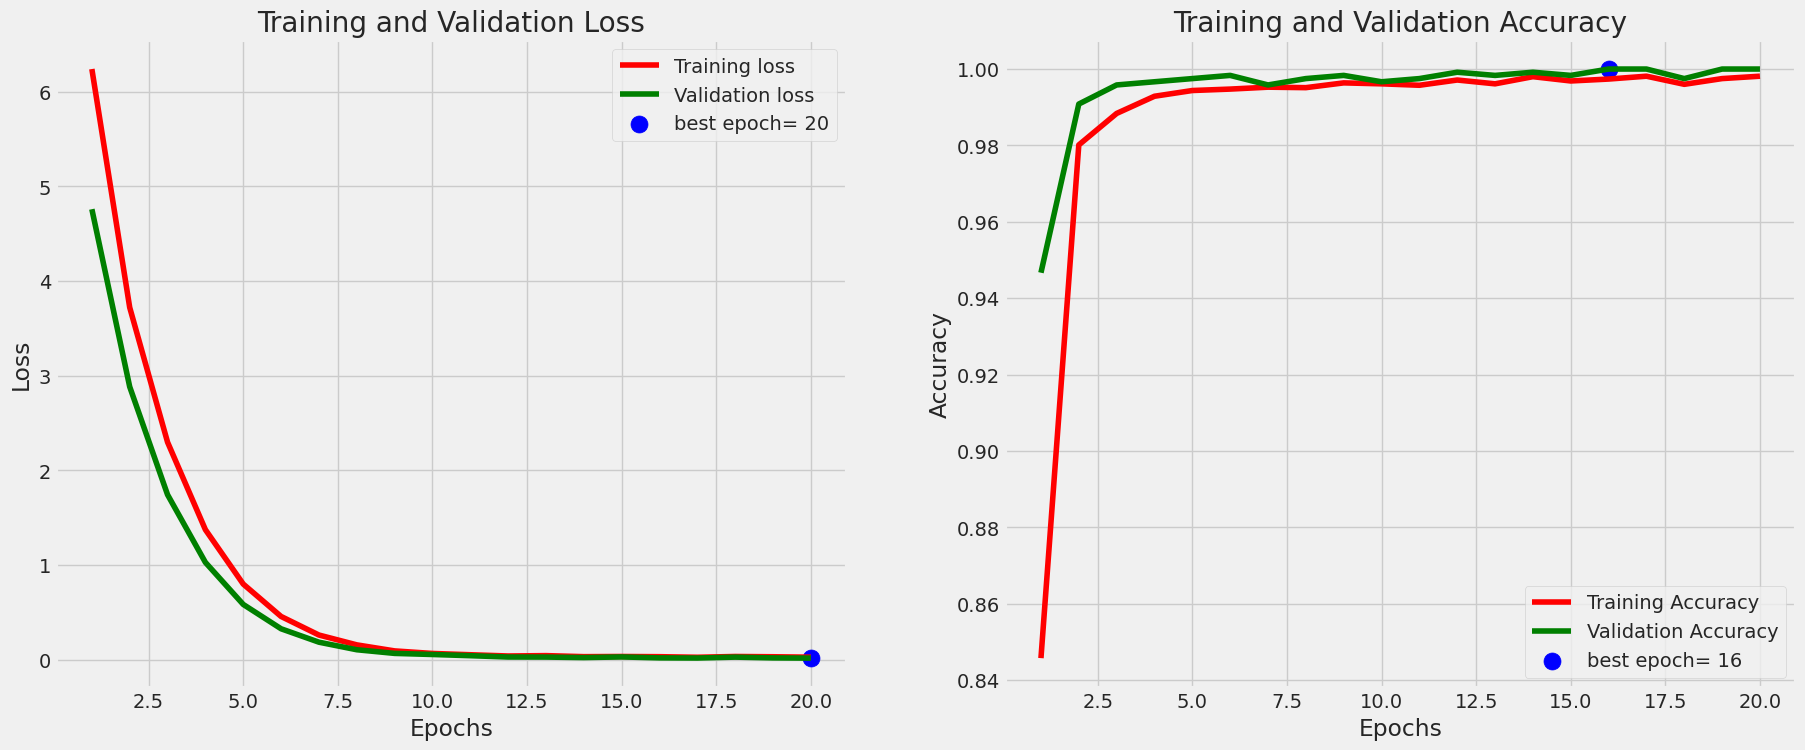

In [38]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [40]:
#Save the model
model.save('Malaria Cells.h5')

In [42]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Malaria Cells.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [43]:
image_path = '/kaggle/input/drugsvision/Data Combined/Bioflu/00000006.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Bioflu


In [44]:
image_path = '/kaggle/input/drugsvision/Data Combined/Fish Oil/00000024.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fish Oil


In [ ]:
#100 Percent accurate model.